In [ ]:
! pip install opendatasets

In [ ]:
import opendatasets as od
import numpy as np
import random

In [ ]:
od.download('https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sebastianspratz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset


100%|██████████| 1.06G/1.06G [00:06<00:00, 171MB/s]


In [ ]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [ ]:
print(f"Original shapes: X: {X.shape}, y: {y.shape}")

Original shapes: X: (22801, 128, 128, 3), y: (22801, 1)


In [ ]:
# due to computational constraints:
max_samples_per_category = 120
unique_labels = np.unique(y)
# Create a list to store the selected images and labels
X_selected = []
y_selected = []

# Randomly select up to 50 images per category
for label in unique_labels:
    # Get indices of all images with the current label
    indices = np.where(y == label)[0]

    # Randomly sample up to 50 indices for the current label
    if len(indices) > max_samples_per_category:
        selected_indices = random.sample(list(indices), max_samples_per_category)
    else:
        selected_indices = indices  # Use all images if less than 50

    # Append the selected images and labels to the lists
    X_selected.extend(X[selected_indices])
    y_selected.extend(y[selected_indices])

# Convert lists to numpy arrays
X_selected = np.array(X_selected)
y_selected = np.array(y_selected)

print(f"Selected dataset shape: X_selected: {X_selected.shape}, y_selected: {y_selected.shape}")

Selected dataset shape: X_selected: (3240, 128, 128, 3), y_selected: (3240, 1)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
label_encoder = LabelEncoder()

y_selected_ravel = y_selected.ravel()

y_encoded = label_encoder.fit_transform(y_selected_ravel)  # Convert strings to integers
num_classes = len(label_encoder.classes_)  # Number of unique classes
y_categorical = to_categorical(y_encoded, num_classes=num_classes)  # One-hot encode

In [ ]:
# Step 4: Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 5: Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).shuffle(1000)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

# Model 01: Vanilla CNN

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
# Step 6: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer matches num_classes
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │       3,211,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 27)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,269,403 (12.47 MB)

 Trainable params: 3,269,403 (12.47 MB)

 Non-trainable params: 0 (0.00 B)

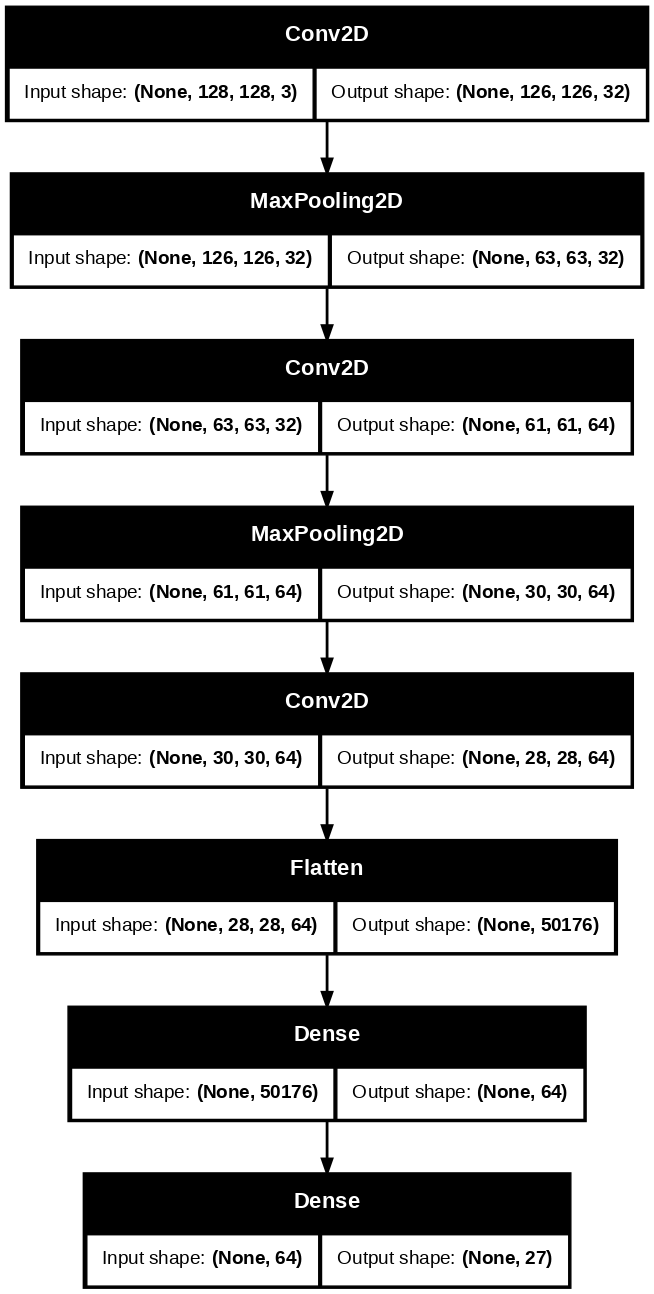

In [ ]:
plot_model(model,
           show_shapes = True,
           dpi = 100)

In [ ]:
# Step 8: Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

# Step 9: Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Optional: Map predictions back to string labels
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

Epoch 1/10
81/81 [==============================] - 61s 742ms/step - loss: 3.3004 - accuracy: 0.0532 - val_loss: 3.2617 - val_accuracy: 0.0648
Epoch 2/10
81/81 [==============================] - 58s 714ms/step - loss: 3.0199 - accuracy: 0.1559 - val_loss: 3.0039 - val_accuracy: 0.1543
Epoch 3/10
81/81 [==============================] - 58s 715ms/step - loss: 2.2375 - accuracy: 0.3750 - val_loss: 3.0122 - val_accuracy: 0.2253
Epoch 4/10
81/81 [==============================] - 58s 718ms/step - loss: 1.1872 - accuracy: 0.6601 - val_loss: 3.2425 - val_accuracy: 0.2716
Epoch 5/10
81/81 [==============================] - 57s 708ms/step - loss: 0.4053 - accuracy: 0.8893 - val_loss: 4.3553 - val_accuracy: 0.2562
Epoch 6/10
81/81 [==============================] - 57s 708ms/step - loss: 0.1905 - accuracy: 0.9514 - val_loss: 5.3146 - val_accuracy: 0.2778
Epoch 7/10
81/81 [==============================] - 57s 702ms/step - loss: 0.0744 - accuracy: 0.9838 - val_loss: 5.8301 - val_accuracy: 0.2870

# Model 02: ResNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Input, Rescaling, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet_v2

In [ ]:
pretrained_model = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top = False,
    input_shape = (128, 128, 3)
)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
pretrained_model.trainable = False

In [ ]:
IMG_SIZE = (128, 128)

i = Input(shape = IMG_SIZE + (3,))
x = pretrained_model(i)
print(f'Shape after passing inputs through base model: {x.shape}')
x = GlobalAveragePooling2D()(x)
print(f'Shape after passing inputs through global average pooling: {x.shape}')
o = Dense(num_classes, activation = 'softmax')(x)

m0 = Model(i, o)

Shape after passing inputs through base model: (None, 4, 4, 2048)
Shape after passing inputs through global average pooling: (None, 2048)


In [ ]:
pretrained_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 32, 32, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 32, 32, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 34, 34, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
plot_model(pretrained_model,
           show_shapes = True,
           dpi = 100)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
m0.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 4, 4, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 27)                  │          55,323 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,620,123 (90.10 MB)

 Trainable params: 55,323 (216.11 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

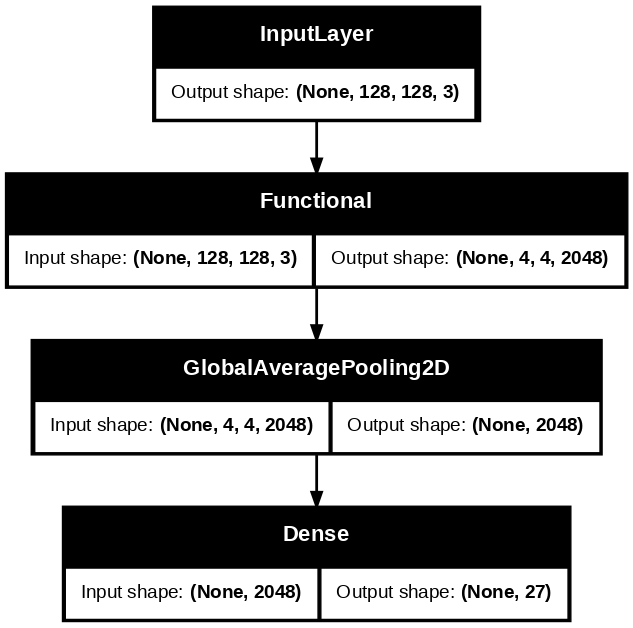

In [ ]:
plot_model(m0,
           show_shapes = True,
           dpi = 100)

In [ ]:
m0.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)
r0 = m0.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
81/81 [==============================] - 189s 2s/step - loss: 2.5761 - accuracy: 0.2944 - val_loss: 1.7838 - val_accuracy: 0.4568
Epoch 2/10
81/81 [==============================] - 185s 2s/step - loss: 1.1988 - accuracy: 0.6346 - val_loss: 1.5011 - val_accuracy: 0.5617
Epoch 3/10
81/81 [==============================] - 186s 2s/step - loss: 0.8064 - accuracy: 0.7731 - val_loss: 1.3727 - val_accuracy: 0.6019
Epoch 4/10
81/81 [==============================] - 181s 2s/step - loss: 0.5884 - accuracy: 0.8499 - val_loss: 1.3097 - val_accuracy: 0.5864
Epoch 5/10
81/81 [==============================] - 183s 2s/step - loss: 0.4344 - accuracy: 0.9093 - val_loss: 1.2849 - val_accuracy: 0.6049
Epoch 6/10
81/81 [==============================] - 179s 2s/step - loss: 0.3360 - accuracy: 0.9402 - val_loss: 1.2637 - val_accuracy: 0.5895
Epoch 7/10
81/81 [==============================] - 182s 2s/step - loss: 0.2674 - accuracy: 0.9626 - val_loss: 1.2400 - val_accuracy: 0.6296
Epoch 8/10
81

In [ ]:
# Step 9: Evaluate the model
test_loss, test_acc = m0.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc}")

# Optional: Map predictions back to string labels
predictions = m0.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

11/11 [==============================] - 21s 2s/step - loss: 1.5461 - accuracy: 0.5926
Test Accuracy: 0.5925925970077515
11/11 [==============================] - 21s 2s/step


# Model 03: CNN with RF

In [ ]:
# Step 6: Define the CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Output layer matches num_classes
])

# Step 7: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 8: Train the model
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
81/81 [==============================] - 60s 729ms/step - loss: 3.3190 - accuracy: 0.0305 - val_loss: 3.2962 - val_accuracy: 0.0340
Epoch 2/10
81/81 [==============================] - 57s 700ms/step - loss: 3.2712 - accuracy: 0.0683 - val_loss: 3.2108 - val_accuracy: 0.0895
Epoch 3/10
81/81 [==============================] - 56s 692ms/step - loss: 2.8731 - accuracy: 0.1836 - val_loss: 3.0038 - val_accuracy: 0.1636
Epoch 4/10
81/81 [==============================] - 56s 691ms/step - loss: 1.8505 - accuracy: 0.4680 - val_loss: 3.0044 - val_accuracy: 0.2191
Epoch 5/10
81/81 [==============================] - 57s 702ms/step - loss: 0.7782 - accuracy: 0.7758 - val_loss: 4.0295 - val_accuracy: 0.2253
Epoch 6/10
81/81 [==============================] - 57s 699ms/step - loss: 0.2546 - accuracy: 0.9302 - val_loss: 6.3425 - val_accuracy: 0.2284
Epoch 7/10
81/81 [==============================] - 56s 695ms/step - loss: 0.0742 - accuracy: 0.9853 - val_loss: 6.9324 - val_accuracy: 0.2500

In [ ]:
import numpy as np
from tensorflow.keras.models import Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assume 'cnn_model' is your trained CNN model
# Remove the final dense layer and create a feature extractor
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)

# Extract features from training data
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Flatten features if necessary
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train a Random Forest classifier on the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")


11/11 [==============================] - 2s 160ms/step
Random Forest Accuracy: 0.04


# Model 04: ResNet with RF

In [ ]:
# Assume 'cnn_model' is your trained CNN model
# Remove the final dense layer and create a feature extractor
feature_extractor = Model(inputs=m0.input, outputs=m0.layers[-2].output)

# Extract features from training data
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Flatten features if necessary
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train a Random Forest classifier on the extracted features
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_features, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test_features)

# Evaluate the Random Forest model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.2f}")
